# PanClassif Analysis with MAGIC smoothing

In [1]:
# import panclassif as pc
import pandas as pd
import numpy as np
from panclassif import dataProcess, featSelect, upsampled, binary_merge, multi_merge, classification
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef, balanced_accuracy_score, f1_score, fbeta_score, recall_score, precision_score, average_precision_score, confusion_matrix
import optuna
from sklearn.exceptions import ConvergenceWarning
import warnings
import logging
import optuna
import optuna.visualization as vis  
from tqdm import tqdm
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, message="OptunaSearchCV is experimental")
logging.getLogger('optuna').setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.ERROR)
optuna.logging.disable_default_handler()

### Custom functions for Optuna optimization

In [2]:
def objective(trial, X_train, y_train, X_val, y_val, classification_type):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 500, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 300)

    # Create and fit random forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_val)

    if classification_type == 'bin':
        average = 'binary'
    else:
        average = 'macro'

    # Calculate metrics
    mcc = matthews_corrcoef(y_val, y_pred)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average=average)
    f2 = fbeta_score(y_val, y_pred, beta=2, average=average)
    recall = recall_score(y_val, y_pred, average=average)
    precision = precision_score(y_val, y_pred, average=average)
    
    if classification_type == 'bin':
        avg_precision = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        specificity = tn / (tn + fp)
        npv = tn / (tn + fn)
    else:
        avg_precision = np.nan 
        specificity = np.nan
        npv = np.nan

    return mcc

In [3]:
def perform_cv(X, y, classification_type, rounds=5, n_trials=50):
    # Initialize dictionaries and lists to store scores and hyperparameters
    cv_scores = {'accuracy': [], 'mcc': [], 'balanced_accuracy': [], 'f1_score': [], 'f2_score': [],
                 'recall': [], 'precision': [], 'average_precision': [], 'specificity': [], 'npv': []}
    cv_params = []
    all_studies = []  # To store all Optuna studies

    # Generate random states for each round and fold
    np.random.seed(42)
    seeds = np.random.randint(1, 1000, size=rounds * 5)
    print("Generated Seeds:", seeds)

    # Perform cross-validation for each round
    for round_idx in range(rounds):
        print(f"Round {round_idx + 1}")

        round_seed = seeds[round_idx]
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=round_seed)

        # Initialize lists to store fold results
        fold_accuracies = []
        fold_mccs = []
        fold_balanced_accs = []
        fold_f1_scores = []
        fold_f2_scores = []
        fold_recalls = []
        fold_precisions = []
        fold_avg_precisions = []
        fold_specificities = []
        fold_npvs = []
        fold_params = []

        for fold_idx, (train_idx, val_idx) in enumerate(tqdm(cv.split(X, y), desc=f"CV Progress (Round {round_idx + 1})")):
            print(f"  Fold {fold_idx + 1}")
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            # Inner cross-validation
            fold_seed = seeds[round_idx * 5 + fold_idx]
            study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=fold_seed))
            study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, classification_type), n_trials=n_trials, show_progress_bar=True)

            # Store the best trial and parameters
            best_trial = study.best_trial
            best_params = best_trial.params

            # Train the model with the best hyperparameters on the training data
            model = RandomForestClassifier(
                n_estimators=best_params['n_estimators'],
                max_depth=best_params['max_depth'],
                random_state=42,
            )
            model.fit(X_train, y_train)

            # Evaluate on the validation set
            y_pred = model.predict(X_val)
            accuracy = accuracy_score(y_val, y_pred)
            mcc = matthews_corrcoef(y_val, y_pred)
            balanced_acc = balanced_accuracy_score(y_val, y_pred)
            f1 = f1_score(y_val, y_pred, average='macro')
            f2 = fbeta_score(y_val, y_pred, beta=2, average='macro')
            recall = recall_score(y_val, y_pred, average='macro')
            precision = precision_score(y_val, y_pred, average='macro')
            
            if classification_type == 'bin':
                avg_precision = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])
                tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
                specificity = tn / (tn + fp)
                npv = tn / (tn + fn)
            else:
                avg_precision = np.nan  # Not applicable for multiclass
                specificity = np.nan
                npv = np.nan

            # Store fold results
            fold_accuracies.append(accuracy)
            fold_mccs.append(mcc)
            fold_balanced_accs.append(balanced_acc)
            fold_f1_scores.append(f1)
            fold_f2_scores.append(f2)
            fold_recalls.append(recall)
            fold_precisions.append(precision)
            fold_avg_precisions.append(avg_precision)
            fold_specificities.append(specificity)
            fold_npvs.append(npv)
            fold_params.append(best_params)

            # Store the study for this fold
            all_studies.append(study)

        # Calculate median scores for the round
        median_accuracy = np.median(fold_accuracies)
        median_mcc = np.median(fold_mccs)

        # Store round results
        cv_scores['accuracy'].append(median_accuracy)
        cv_scores['mcc'].append(median_mcc)
        cv_scores['balanced_accuracy'].append(np.median(fold_balanced_accs))
        cv_scores['f1_score'].append(np.median(fold_f1_scores))
        cv_scores['f2_score'].append(np.median(fold_f2_scores))
        cv_scores['recall'].append(np.median(fold_recalls))
        cv_scores['precision'].append(np.median(fold_precisions))
        cv_scores['average_precision'].append(np.median(fold_avg_precisions))
        cv_scores['specificity'].append(np.median(fold_specificities))
        cv_scores['npv'].append(np.median(fold_npvs))
        cv_params.append(fold_params)

    return cv_scores, cv_params, all_studies

In [4]:
def get_best_params_and_study(all_studies):
    # Initialize variables to store the best trial, its score, and the corresponding study
    best_trial = None
    best_value = -np.inf
    best_study = None

    # Iterate over all studies
    for study in all_studies:
        # Get the best trial from the current study
        trial = study.best_trial
        # Update best_trial, best_value, and best_study if the current trial is better
        if trial.value > best_value:
            best_value = trial.value
            best_trial = trial
            best_study = study

    # Return the best hyperparameters and the best study
    return best_trial.params, best_study

Function for extraction of train test per experiment

In [5]:
def load_data(homepath, classification_type):
    """
    Load the data for binary or multiclass classification.

    Parameters:
    homepath (str): The path to the data files.
    classification_type (str): The type of classification ('bin' or 'multi').

    Returns:
    X (numpy.ndarray): The feature matrix.
    y (numpy.ndarray): The target vector.
    """
    if classification_type == 'bin':
        Cancer = pd.read_csv(f"{homepath}/train_data/bin_Cancer.txt.bz2", header=None, delimiter="\t")
        Normal = pd.read_csv(f"{homepath}/train_data/bin_Normal.txt.bz2", header=None, delimiter="\t")
        Cancer['Target'] = 1
        Normal['Target'] = 0
        Data = pd.concat([Cancer, Normal], axis=0)
    elif classification_type == 'multi':
        Cancer = pd.read_csv(f"{homepath}/train_data/mul_Cancer.txt.bz2", header=None, delimiter="\t")
        Normal = pd.read_csv(f"{homepath}/train_data/mul_Normal.txt.bz2", header=None, delimiter="\t")
        Normal = Normal.drop(Normal.index[0])  # Drop the first row from Normal
        Data = pd.concat([Cancer, Normal], axis=0)
        Data = Data.drop(Data.index[0])  # Drop the first row from Data
    else:
        raise ValueError("Invalid classification_type. Expected 'bin' or 'multi'.")

    X = Data.iloc[:, :-1].values
    y = Data.iloc[:, -1].values

    return X, y

### Rare Data

In [6]:
homepath_rare = './rare'
cancerpath_rare = './rare/cancer'
normalpath_rare = './rare/normal'

# Feature selection
names_rare = featSelect(homepath_rare,cancerpath_rare,normalpath_rare, k=5)

smoothed_cancer_rare = './rare/smoothed_cancer_magic'
smoothed_normal_rare = './rare/smoothed_normal_magic'

# Data process
dataProcess(homepath=homepath_rare,
            names=names_rare,
            cancerpath=cancerpath_rare,
            smoothed_cancer=smoothed_cancer_rare,
            smoothed_normal=smoothed_normal_rare,
            scale_mode=0,
            cancer='CHOL')

# Upsample training data
upsampled(names_rare, homepath_rare)

# Merge data (all rare datasets)
binary_merge(names_rare, homepath_rare)
multi_merge(names_rare, homepath_rare)

Cancer files: ['SARC.csv.gz', 'PCPG.csv.gz', 'THYM.csv.gz', 'KICH.csv.gz', 'CHOL.csv.gz']
Normal files: ['PCPG.norm.csv.gz', 'THYM.norm.csv.gz', 'CHOL.norm.csv.gz', 'KICH.norm.csv.gz', 'SARC.norm.csv.gz']
Feature selection process is running...
Processing file index: 0
Doing feature selection for CHOL
Processing file index: 1
Doing feature selection for KICH
Processing file index: 2
Doing feature selection for PCPG
Processing file index: 3
Doing feature selection for SARC
Processing file index: 4
Doing feature selection for THYM
Feature selection process has ended

Data process is running
Unique genes: 25
CHOL
(45, 25)
(9, 25)
KICH
(91, 25)
(25, 25)
PCPG
(187, 25)
(3, 25)
SARC
(265, 25)
(2, 25)
THYM
(122, 25)
(2, 25)
Data process has ended

Upsampling on train data is running
Upsampling on train data has ended

Merging for binary has started
Merging for binary has ended

Merging for multiclass has started
Merging for multiclass has ended



#### Cross-Validation

In [7]:
# Load train data
X_bin_rare, y_bin_rare = load_data(homepath=homepath_rare, classification_type="bin")
X_multi_rare, y_multi_rare = load_data(homepath=homepath_rare, classification_type="multi")

Binary tuning

In [8]:
# Perform cv with optuna
cv_scores_bin_rare, cv_params_bin_rare, studies_bin_rare = perform_cv(X_bin_rare, y_bin_rare, classification_type='bin')

# Print CV scores and parameters
print("CV Scores:", cv_scores_bin_rare)
print("CV Parameters:", cv_params_bin_rare)

Generated Seeds: [103 436 861 271 107  72 701  21 615 122 467 215 331 459  88 373 100 872
 664 131 662 309 770 344 492]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:05,  5.10s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [00:09,  4.92s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [00:14,  4.94s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [00:17,  4.21s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [00:21,  4.24s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:04,  4.63s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [00:08,  4.47s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [00:13,  4.38s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [00:20,  5.46s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [00:23,  4.75s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:04,  4.51s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [00:12,  6.40s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [00:23,  8.59s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [00:26,  6.60s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [00:30,  6.05s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:05,  5.14s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [00:10,  5.05s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [00:15,  5.16s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [00:18,  4.22s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [00:23,  4.65s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:06,  6.19s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [00:12,  5.99s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [00:18,  6.37s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [00:22,  5.33s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [00:27,  5.43s/it]

CV Scores: {'accuracy': [1.0, 1.0, 1.0, 1.0, 0.9929577464788732], 'mcc': [1.0, 1.0, 1.0, 1.0, 0.981037136113543], 'balanced_accuracy': [1.0, 1.0, 1.0, 1.0, 0.9857142857142858], 'f1_score': [1.0, 1.0, 1.0, 1.0, 0.9904280417930569], 'f2_score': [1.0, 1.0, 1.0, 1.0, 0.9875729113055411], 'recall': [1.0, 1.0, 1.0, 1.0, 0.9857142857142858], 'precision': [1.0, 1.0, 1.0, 1.0, 0.9953703703703703], 'average_precision': [1.0, 1.0, 1.0, 1.0, 1.0], 'specificity': [1.0, 1.0, 1.0, 1.0, 0.9714285714285714], 'npv': [1.0, 1.0, 1.0, 1.0, 1.0]}
CV Parameters: [[{'n_estimators': 53, 'max_depth': 54}, {'n_estimators': 24, 'max_depth': 225}, {'n_estimators': 182, 'max_depth': 209}, {'n_estimators': 13, 'max_depth': 192}, {'n_estimators': 37, 'max_depth': 47}], [{'n_estimators': 71, 'max_depth': 168}, {'n_estimators': 15, 'max_depth': 190}, {'n_estimators': 166, 'max_depth': 8}, {'n_estimators': 415, 'max_depth': 12}, {'n_estimators': 18, 'max_depth': 211}], [{'n_estimators': 188, 'max_depth': 276}, {'n_estim

Multi-class tuning

In [9]:
# Perform cv with optuna
cv_scores_multi_rare, cv_params_multi_rare, studies_multi_rare = perform_cv(X_multi_rare, y_multi_rare, classification_type='multi')

# Print CV scores and parameters
print("CV Scores:", cv_scores_multi_rare)
print("CV Parameters:", cv_params_multi_rare)

Generated Seeds: [103 436 861 271 107  72 701  21 615 122 467 215 331 459  88 373 100 872
 664 131 662 309 770 344 492]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:05,  5.55s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [00:08,  4.23s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [00:19,  7.08s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [00:32,  9.30s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [00:45,  9.07s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:08,  8.42s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [00:12,  6.10s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [00:18,  6.08s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [00:26,  6.57s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [00:33,  6.69s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:05,  5.51s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [00:17,  9.08s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [00:27,  9.77s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [00:38, 10.21s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [00:49,  9.86s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:04,  4.30s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [00:14,  8.03s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [00:20,  7.02s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [00:23,  5.52s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [00:27,  5.46s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:06,  6.93s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [00:10,  5.13s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [00:18,  6.21s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [00:26,  7.02s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [00:32,  6.40s/it]

CV Scores: {'accuracy': [1.0, 0.9929577464788732, 1.0, 1.0, 1.0], 'mcc': [1.0, 0.9911960805402545, 1.0, 1.0, 1.0], 'balanced_accuracy': [1.0, 0.9907407407407408, 1.0, 1.0, 1.0], 'f1_score': [1.0, 0.9841269841269842, 1.0, 1.0, 1.0], 'f2_score': [1.0, 0.9878797336662505, 1.0, 1.0, 1.0], 'recall': [1.0, 0.9907407407407408, 1.0, 1.0, 1.0], 'precision': [1.0, 0.9916666666666667, 1.0, 1.0, 1.0], 'average_precision': [nan, nan, nan, nan, nan], 'specificity': [nan, nan, nan, nan, nan], 'npv': [nan, nan, nan, nan, nan]}
CV Parameters: [[{'n_estimators': 53, 'max_depth': 54}, {'n_estimators': 10, 'max_depth': 282}, {'n_estimators': 182, 'max_depth': 209}, {'n_estimators': 487, 'max_depth': 72}, {'n_estimators': 446, 'max_depth': 211}], [{'n_estimators': 153, 'max_depth': 258}, {'n_estimators': 15, 'max_depth': 190}, {'n_estimators': 166, 'max_depth': 8}, {'n_estimators': 415, 'max_depth': 12}, {'n_estimators': 96, 'max_depth': 66}], [{'n_estimators': 188, 'max_depth': 276}, {'n_estimators': 359,

#### Classification with best parameters

In [10]:
best_params_bin_rare, best_study_bin_rare = get_best_params_and_study(studies_bin_rare)
best_params_multi_rare, best_study_multi_rare = get_best_params_and_study(studies_multi_rare)

In [11]:
n_estimators_bin_rare = best_params_bin_rare['n_estimators']
print(n_estimators_bin_rare)

max_depth_bin_rare = best_params_bin_rare['max_depth']
print(max_depth_bin_rare)

53
54


In [12]:
n_estimators_multi_rare = best_params_multi_rare['n_estimators']
print(n_estimators_multi_rare)

max_depth_multi_rare = best_params_multi_rare['max_depth']
print(max_depth_multi_rare)

53
54


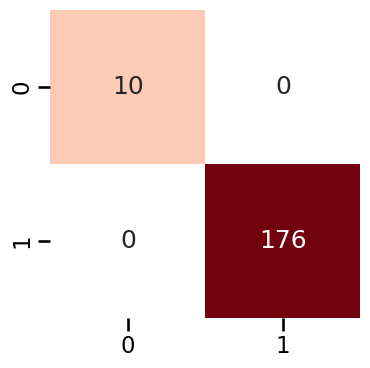

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00       176

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186

MCC Score:  1.0


<Figure size 640x480 with 0 Axes>

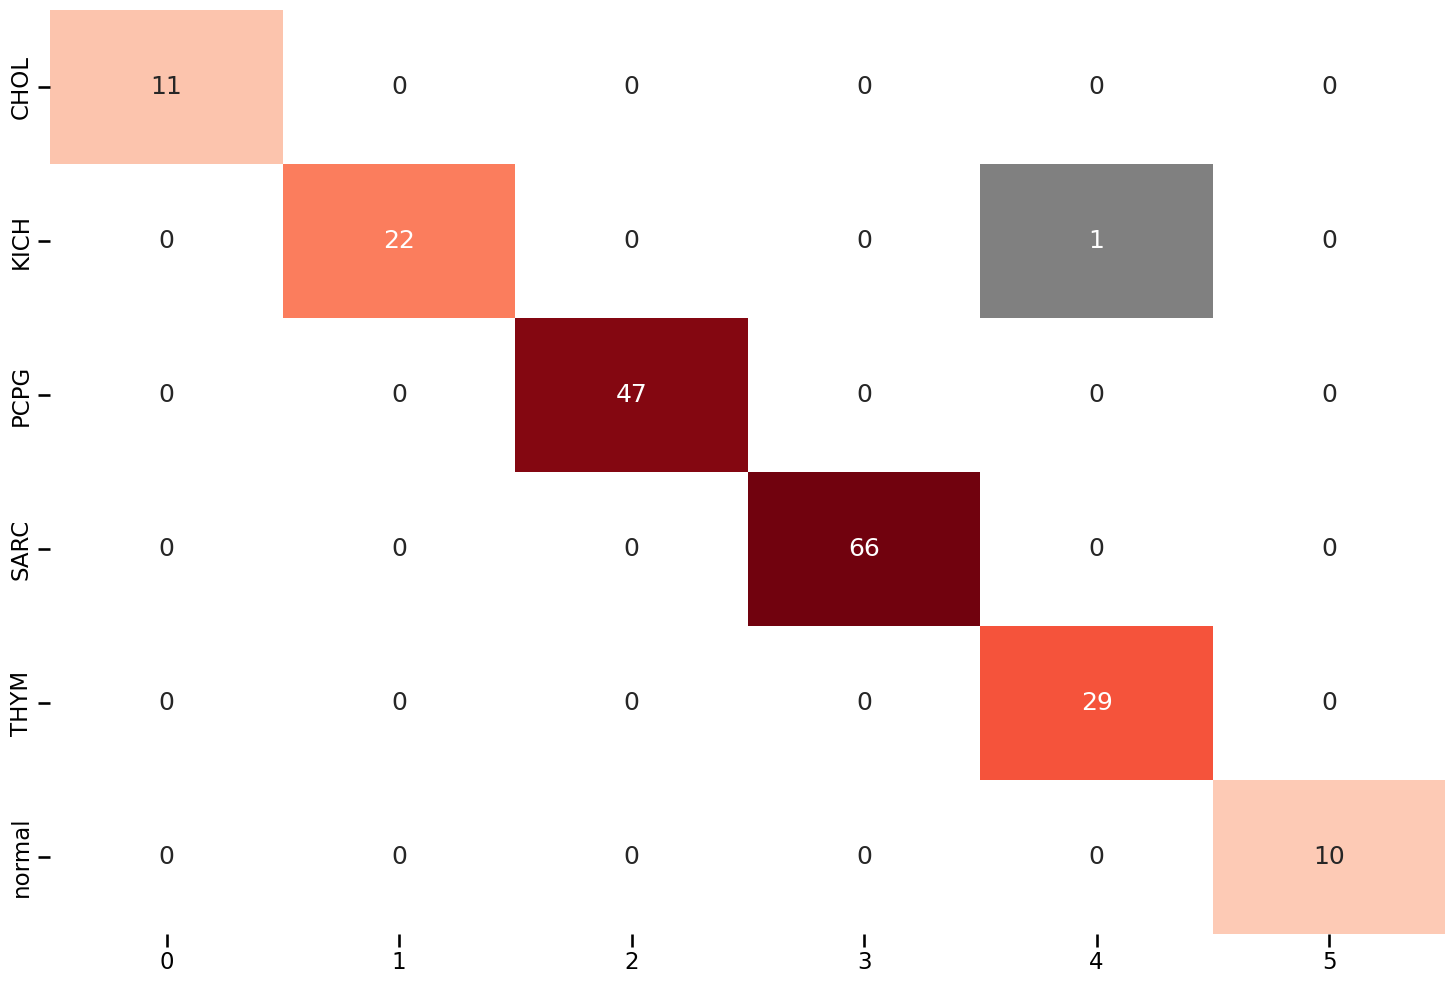

              precision    recall  f1-score   support

        CHOL       1.00      1.00      1.00        11
        KICH       1.00      0.96      0.98        23
        PCPG       1.00      1.00      1.00        47
        SARC       1.00      1.00      1.00        66
        THYM       0.97      1.00      0.98        29
      normal       1.00      1.00      1.00        10

    accuracy                           0.99       186
   macro avg       0.99      0.99      0.99       186
weighted avg       0.99      0.99      0.99       186

MCC Score:  0.9930012075959879


<Figure size 640x480 with 0 Axes>

In [13]:
# Classification
classification(homepath_rare, RandomForestClassifier(n_estimators=n_estimators_bin_rare, max_depth=max_depth_bin_rare, random_state=42), mode="binary", save_model="RF")
classification(homepath_rare, RandomForestClassifier(n_estimators=n_estimators_multi_rare, max_depth=max_depth_multi_rare, random_state=42), mode="multi", save_model="RF")

### Common Data

In [14]:
homepath_common = './common'
cancerpath_common = './common/cancer'
normalpath_common = './common/normal'

# Feature selection
names_common = featSelect(homepath_common,cancerpath_common,normalpath_common, k=5)

smoothed_cancer_common = './common/smoothed_cancer_magic'
smoothed_normal_common = './common/smoothed_normal_magic'

# Data process
dataProcess(homepath=homepath_common,
            names=names_common,
            cancerpath=cancerpath_common,
            smoothed_cancer=smoothed_cancer_common,
            smoothed_normal=smoothed_normal_common,
            scale_mode=0,
            cancer='BRCA')

# Upsample training data
upsampled(names_common, homepath_common)

# Merge data (all common datasets)
binary_merge(names_common, homepath_common)
multi_merge(names_common, homepath_common)

Cancer files: ['BRCA.csv.gz', 'LUAD.csv.gz', 'COAD.csv.gz', 'LUSC.csv.gz', 'PRAD.csv.gz', 'UCEC.csv.gz', 'READ.csv.gz']
Normal files: ['LUAD.norm.csv.gz', 'READ.norm.csv.gz', 'UCEC.norm.csv.gz', 'COAD.norm.csv.gz', 'LUSC.norm.csv.gz', 'BRCA.norm.csv.gz', 'PRAD.norm.csv.gz']
Feature selection process is running...
Processing file index: 0
Doing feature selection for BRCA
Processing file index: 1
Doing feature selection for COAD
Processing file index: 2
Doing feature selection for LUAD
Processing file index: 3
Doing feature selection for LUSC
Processing file index: 4
Doing feature selection for PRAD
Processing file index: 5
Doing feature selection for READ
Processing file index: 6
Doing feature selection for UCEC
Feature selection process has ended

Data process is running
Unique genes: 35
BRCA
(1212, 35)
(112, 35)
COAD
(328, 35)
(26, 35)
LUAD
(576, 35)
(58, 35)
LUSC
(552, 35)
(51, 35)
PRAD
(550, 35)
(52, 35)
READ
(105, 35)
(6, 35)
UCEC
(201, 35)
(7, 35)
Data process has ended

Upsamplin

#### Cross-validation

In [15]:
# Load train data
X_bin_common, y_bin_common = load_data(homepath=homepath_common, classification_type="bin")
X_multi_common, y_multi_common = load_data(homepath=homepath_common, classification_type="multi")

Binary tuning

In [16]:
# Perform cv with optuna
cv_scores_bin_common, cv_params_bin_common, studies_bin_common = perform_cv(X_bin_common, y_bin_common, classification_type='bin')

# Print CV scores and parameters
print("CV Scores:", cv_scores_bin_common)
print("CV Parameters:", cv_params_bin_common)

Generated Seeds: [103 436 861 271 107  72 701  21 615 122 467 215 331 459  88 373 100 872
 664 131 662 309 770 344 492]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:21, 21.05s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [00:59, 31.10s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [01:39, 35.17s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [02:21, 38.06s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [02:37, 31.43s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [00:40, 40.98s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [01:22, 41.17s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [01:34, 27.78s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [01:48, 22.38s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [02:24, 28.96s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [00:12, 12.18s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [00:38, 20.63s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [01:08, 24.78s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [01:53, 32.73s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [02:11, 26.22s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [01:05, 65.07s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [01:57, 57.52s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [03:12, 65.73s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [04:27, 69.36s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [04:49, 57.85s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:44, 44.20s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [01:51, 57.97s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [02:11, 40.46s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [03:20, 51.81s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [03:41, 44.24s/it]

CV Scores: {'accuracy': [0.9928977272727273, 0.9957386363636364, 0.9957386363636364, 0.9943181818181818, 0.9943181818181818], 'mcc': [0.9813424357814607, 0.9887216847368875, 0.9885783548886485, 0.984761021893588, 0.9848769097681769], 'balanced_accuracy': [0.9952741020793952, 0.997164461247637, 0.994301948051948, 0.9933712121212122, 0.9943073183904942], 'f1_score': [0.9905835774380375, 0.9943289072674302, 0.9942855751357582, 0.9923660811103883, 0.9924242424242424], 'f2_score': [0.9933712121212122, 0.9960205649409658, 0.9937174717331632, 0.9912321584745921, 0.9935497954839507], 'recall': [0.9952741020793952, 0.997164461247637, 0.994301948051948, 0.9933712121212122, 0.9943073183904942], 'precision': [0.9888268156424581, 0.9915730337078652, 0.9933712121212122, 0.9933712121212122, 0.9914226848839731], 'average_precision': [0.9999502587098464, 0.999964479963706, 0.9999069433684112, 0.9999466539193445, 0.9999432999762741], 'specificity': [1.0, 1.0, 0.9942857142857143, 0.9942857142857143, 0.99

Multi-class tuning

In [17]:
# Perform cv with optuna
cv_scores_multi_common, cv_params_multi_common, studies_multi_common = perform_cv(X_multi_common, y_multi_common, classification_type='multi')

# Print CV scores and parameters
print("CV Scores:", cv_scores_multi_common)
print("CV Parameters:", cv_params_multi_common)

Generated Seeds: [103 436 861 271 107  72 701  21 615 122 467 215 331 459  88 373 100 872
 664 131 662 309 770 344 492]
Round 1


CV Progress (Round 1): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 1it [00:34, 34.18s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 2it [01:59, 64.51s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 3it [02:31, 49.58s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 4it [03:54, 62.84s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 1): 5it [04:20, 52.06s/it]


Round 2


CV Progress (Round 2): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 1it [01:35, 95.63s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 2it [01:55, 51.03s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 3it [02:52, 53.67s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 4it [03:54, 57.09s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 2): 5it [05:11, 62.30s/it]


Round 3


CV Progress (Round 3): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 1it [01:28, 88.70s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 2it [02:32, 73.97s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 3it [03:33, 68.02s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 4it [04:48, 70.88s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 3): 5it [06:14, 74.86s/it]


Round 4


CV Progress (Round 4): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 1it [00:59, 59.06s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 2it [01:53, 56.21s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 3it [03:17, 69.11s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 4it [04:13, 64.03s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 4): 5it [04:49, 57.87s/it]


Round 5


CV Progress (Round 5): 0it [00:00, ?it/s]

  Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 1it [00:35, 35.80s/it]

  Fold 2


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 2it [01:30, 47.19s/it]

  Fold 3


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 3it [02:58, 65.76s/it]

  Fold 4


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 4it [03:56, 62.72s/it]

  Fold 5


  0%|          | 0/50 [00:00<?, ?it/s]

CV Progress (Round 5): 5it [05:18, 63.61s/it]

CV Scores: {'accuracy': [0.9857954545454546, 0.9886201991465149, 0.9857954545454546, 0.9871977240398293, 0.984375], 'mcc': [0.9827646445248538, 0.9861835241801935, 0.9827373386714867, 0.9844377306918788, 0.9810629642806087], 'balanced_accuracy': [0.9686353123914964, 0.9720769379029996, 0.9655725731912335, 0.9722731089735437, 0.9617434677735331], 'f1_score': [0.9794184751094859, 0.982285245287426, 0.9774655350783836, 0.9808696925280573, 0.9722058428432141], 'f2_score': [0.9728011670698711, 0.9759065682670905, 0.9700596028399818, 0.9755826694583273, 0.9655948192897345], 'recall': [0.9686353123914964, 0.9720769379029996, 0.9655725731912335, 0.9722731089735437, 0.9617434677735331], 'precision': [0.9914679190052373, 0.9897573126546483, 0.9886120188816268, 0.9895775911570486, 0.9858358263655768], 'average_precision': [nan, nan, nan, nan, nan], 'specificity': [nan, nan, nan, nan, nan], 'npv': [nan, nan, nan, nan, nan]}
CV Parameters: [[{'n_estimators': 248, 'max_depth': 247}, {'n_estimators':

Best parameters

In [18]:
best_params_bin_common, best_study_bin_common = get_best_params_and_study(studies_bin_common)
best_params_multi_common, best_study_multi_common = get_best_params_and_study(studies_multi_common)

In [19]:
n_estimators_bin_common = best_params_bin_common['n_estimators']
print(n_estimators_bin_common)

max_depth_bin_common = best_params_bin_common['max_depth']
print(max_depth_bin_common)

394
94


In [20]:
n_estimators_multi_common = best_params_multi_common['n_estimators']
print(n_estimators_multi_common)

max_depth_multi_common = best_params_multi_common['max_depth']
print(max_depth_multi_common)

268
31


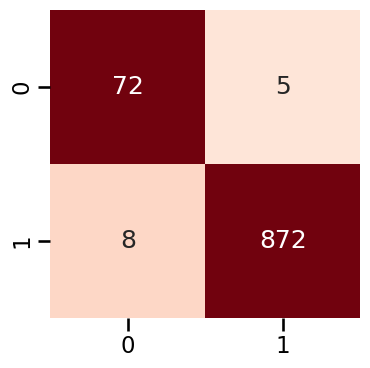

              precision    recall  f1-score   support

           0       0.90      0.94      0.92        77
           1       0.99      0.99      0.99       880

    accuracy                           0.99       957
   macro avg       0.95      0.96      0.95       957
weighted avg       0.99      0.99      0.99       957

MCC Score:  0.9099985769228591


<Figure size 640x480 with 0 Axes>

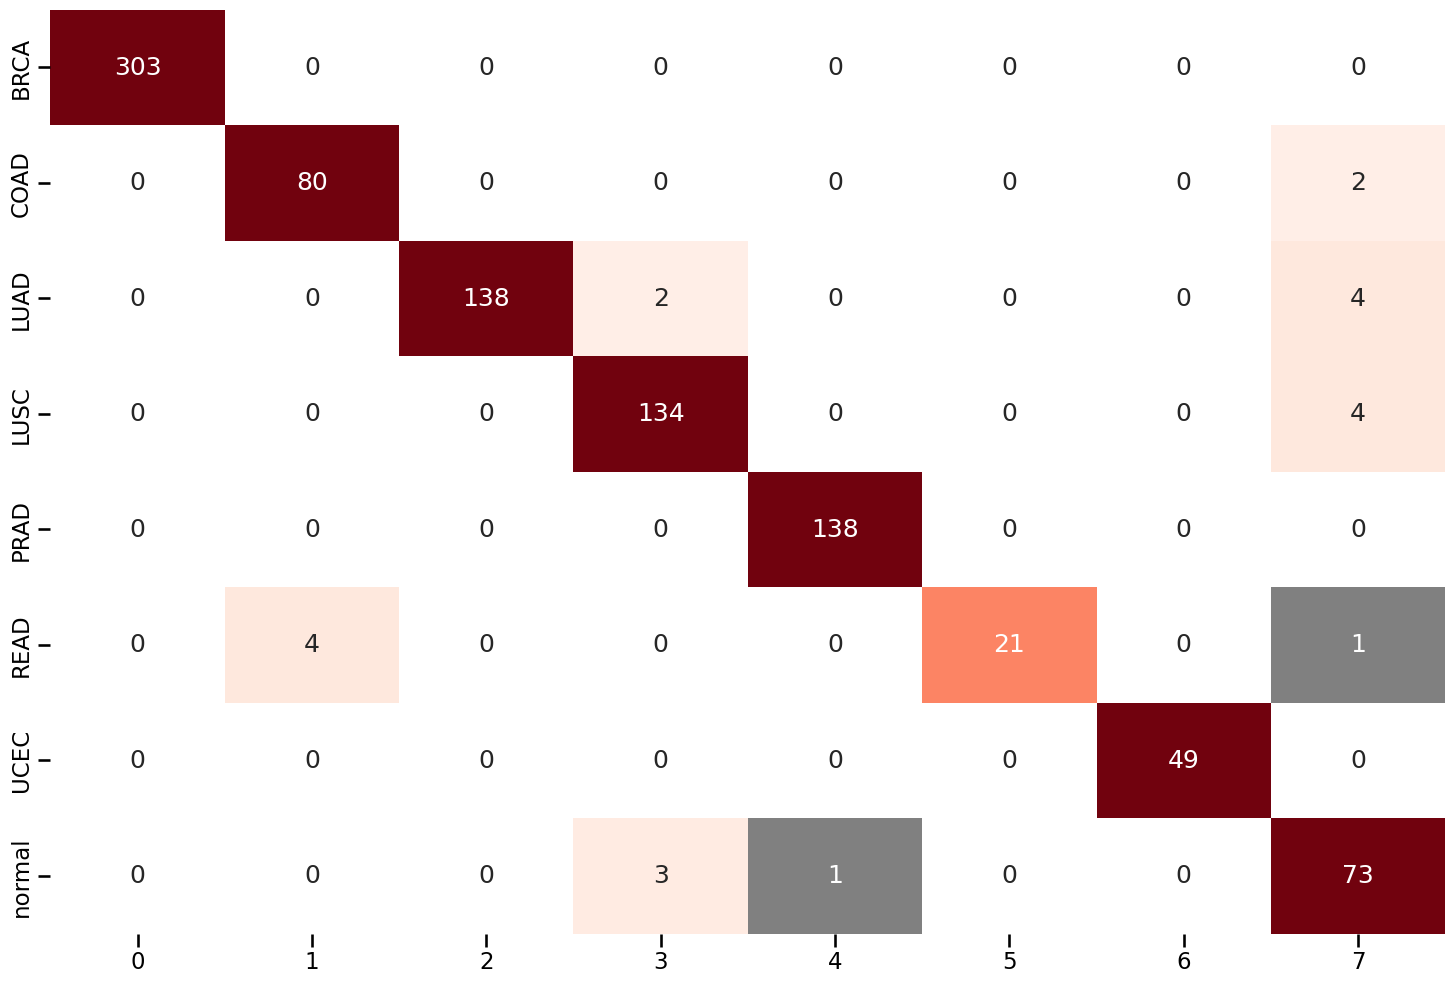

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00       303
        COAD       0.95      0.98      0.96        82
        LUAD       1.00      0.96      0.98       144
        LUSC       0.96      0.97      0.97       138
        PRAD       0.99      1.00      1.00       138
        READ       1.00      0.81      0.89        26
        UCEC       1.00      1.00      1.00        49
      normal       0.87      0.95      0.91        77

    accuracy                           0.98       957
   macro avg       0.97      0.96      0.96       957
weighted avg       0.98      0.98      0.98       957

MCC Score:  0.973261477124476


<Figure size 640x480 with 0 Axes>

In [21]:
# Classification
classification(homepath_common, RandomForestClassifier(n_estimators=n_estimators_bin_common, max_depth=max_depth_bin_common, random_state=42), mode="binary", save_model="RF")
classification(homepath_common, RandomForestClassifier(n_estimators=n_estimators_multi_common, max_depth=max_depth_multi_common, random_state=42), mode="multi", save_model="RF")

#### Optuna Visualizations

Optimization history

In [24]:
from IPython.display import display
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Define studies and titles
studies = [best_study_bin_rare, best_study_multi_rare, best_study_bin_common, best_study_multi_common]

study_titles = {
    "study_bin_rare": "Binary Rare",
    "study_multi_rare": "Multi-class Rare",
    "study_bin_common": "Binary Common",
    "study_multi_common": "Multi-class Common"
}

# Function to set a consistent color for each trace
def set_trace_colors(fig, color):
    for trace in fig['data']:
        trace['marker']['color'] = color

# Define the color for the traces
trace_color = '#1862d9'

# Create 2x2 subplot for optimization history
fig_opt_history = make_subplots(rows=2, cols=2, subplot_titles=list(study_titles.values()))

for i, (name, title) in enumerate(study_titles.items(), start=1):
    row, col = divmod(i-1, 2)
    row += 1
    col += 1
    fig = vis.plot_optimization_history(studies[i-1])
    set_trace_colors(fig, trace_color)  # Set the color for traces
    for trace in fig['data']:
        fig_opt_history.add_trace(trace, row=row, col=col)
    fig_opt_history.update_xaxes(title_text='Trials', row=row, col=col)
    fig_opt_history.update_yaxes(title_text='', row=row, col=col)  # Remove y-axis title
    fig_opt_history.update_layout(showlegend=False)  # Hide legend

fig_opt_history.update_layout(height=600, width=1000, title_text="Optimization History", title_x=0.5, template='simple_white')
display(fig_opt_history)
pio.write_image(fig_opt_history, "magic_optimization_history_multiplot.pdf")

# Create 2x2 subplot for parameter importance
fig_param_importance = make_subplots(rows=2, cols=2, subplot_titles=list(study_titles.values()))

for i, (name, title) in enumerate(study_titles.items(), start=1):
    row, col = divmod(i-1, 2)
    row += 1
    col += 1
    fig = vis.plot_param_importances(studies[i-1])
    set_trace_colors(fig, trace_color)  # Set the color for traces
    for trace in fig['data']:
        fig_param_importance.add_trace(trace, row=row, col=col)
    fig_param_importance.update_xaxes(title_text='Hyperparameters', row=row, col=col)
    fig_param_importance.update_yaxes(title_text='', row=row, col=col, tickangle=-65)
    fig_param_importance.update_layout(showlegend=False)  # Hide legend

fig_param_importance.update_layout(height=550, width=1000, title_text="Hyperparameter Importance", title_x=0.5, template='simple_white')
display(fig_param_importance)
pio.write_image(fig_param_importance, "magic_parameter_importance_multiplot.pdf")

Hyperparameter importances

In [25]:
for study in studies:
    fig = vis.plot_parallel_coordinate(study)
    display(fig)